# Import Libraries

In [1]:
import sqlite3
import csv
import time
from datetime import datetime
from IPython.display import display, Markdown
import pandas as pd
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
def display_formatted_output(text, is_bold=False):
    """
    Display formatted output using Markdown.
    If is_bold=True, text is displayed in bold.
    """
    if is_bold:
        display(Markdown(f"**{text}**"))
    else:
        display(Markdown(text))


def parse_date(date_str):
    """
    Parse the given date string in MM/DD/YYYY format
    and return it in YYYY-MM-DD format.
    """
    return datetime.strptime(date_str, '%m/%d/%Y').strftime('%Y-%m-%d')


# Database Loading Function

In [3]:
def create_normalized_schema(db_name):
    """
    Create the normalized database schema.
    If tables exist, they are dropped first.
    """
    conn = sqlite3.connect(db_name, timeout=10)
    conn.execute('PRAGMA journal_mode=WAL')

    tables = ["Person", "School", "Campus", "Department", "JobRecord", "FinancialRecord"]
    for table in tables:
        conn.execute(f"DROP TABLE IF EXISTS {table}")

    conn.execute('''CREATE TABLE Person (
        PersonID INTEGER PRIMARY KEY,
        PersonName TEXT,
        BirthDate TEXT
    )''')

    conn.execute('''CREATE TABLE School (
        SchoolID TEXT PRIMARY KEY,
        SchoolName TEXT
    )''')

    conn.execute('''CREATE TABLE Campus (
        SchoolID TEXT,
        SchoolCampus TEXT,
        PRIMARY KEY (SchoolID, SchoolCampus),
        FOREIGN KEY (SchoolID) REFERENCES School(SchoolID)
    )''')

    conn.execute('''CREATE TABLE Department (
        DepartmentID TEXT PRIMARY KEY,
        DepartmentName TEXT
    )''')

    conn.execute('''CREATE TABLE JobRecord (
        JobID TEXT PRIMARY KEY,
        SchoolID TEXT,
        SchoolCampus TEXT,
        DepartmentID TEXT,
        JobTitle TEXT,
        FOREIGN KEY (SchoolID, SchoolCampus) REFERENCES Campus(SchoolID, SchoolCampus),
        FOREIGN KEY (DepartmentID) REFERENCES Department(DepartmentID)
    )''')

    conn.execute('''CREATE TABLE FinancialRecord (
        PersonID INTEGER,
        Earnings REAL,
        EarningsYear INTEGER,
        JobID TEXT,
        StillWorking TEXT,  
        PRIMARY KEY (PersonID, EarningsYear, JobID),
        FOREIGN KEY (PersonID) REFERENCES Person(PersonID),
        FOREIGN KEY (JobID) REFERENCES JobRecord(JobID)
    );''')

    conn.commit()
    conn.close()


def load_csv_to_normalized_db(csv_file, db_name):
    """
    Load data from the CSV file into the normalized database schema.
    Ensures uniqueness of JobID for each distinct job context by generating 
    new JobIDs as needed to avoid incorrect associations.
    """
    conn = sqlite3.connect(db_name, timeout=10)

    try:
        with open(csv_file, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header

            person_set = set()
            school_set = set()
            campus_set = set()
            department_set = set()

            # Job mapping to ensure unique JobIDs per unique job combination
            job_mapping = {}
            job_counter = {}

            financial_records = []

            for row in reader:
                personID = int(row[0])
                personName = row[1]
                schoolID = row[2]
                schoolName = row[3]
                schoolCampus = row[4]
                deptName = row[5]
                deptID = row[6]
                birthDate = parse_date(row[7])
                stillWorking = row[8]
                original_jobID = row[9]
                jobTitle = row[10]
                earnings = float(row[11])
                earningsYear = int(row[12])

                person_set.add((personID, personName, birthDate))
                school_set.add((schoolID, schoolName))
                campus_set.add((schoolID, schoolCampus))
                department_set.add((deptID, deptName))

                job_key = (original_jobID, schoolID, schoolCampus, deptID, jobTitle)

                if job_key not in job_mapping:
                    base_job_id = original_jobID
                    if base_job_id not in job_counter:
                        job_counter[base_job_id] = 0

                    new_job_id = base_job_id
                    while (new_job_id in job_mapping.values()):
                        job_counter[base_job_id] += 1
                        new_job_id = f"{base_job_id}_{job_counter[base_job_id]}"

                    job_mapping[job_key] = new_job_id

                    conn.execute('INSERT INTO JobRecord (JobID, SchoolID, SchoolCampus, DepartmentID, JobTitle) VALUES (?, ?, ?, ?, ?)',
                                 (new_job_id, schoolID, schoolCampus, deptID, jobTitle))
                
                unique_job_id = job_mapping[job_key]
                financial_records.append((personID, earnings, earningsYear, unique_job_id, stillWorking))

            conn.executemany('INSERT OR IGNORE INTO Person VALUES (?, ?, ?)', list(person_set))
            conn.executemany('INSERT OR IGNORE INTO School VALUES (?, ?)', list(school_set))
            conn.executemany('INSERT OR IGNORE INTO Campus VALUES (?, ?)', list(campus_set))
            conn.executemany('INSERT OR IGNORE INTO Department VALUES (?, ?)', list(department_set))
            conn.executemany('INSERT OR IGNORE INTO FinancialRecord VALUES (?, ?, ?, ?, ?)', financial_records)

            conn.commit()

    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")
        conn.rollback()
    finally:
        conn.close()


# Initialize Database and Load Data
db_names = ['normalized_salary_data_1MB.db',
            'normalized_salary_data_10MB.db',
            'normalized_salary_data_100MB.db']
csv_files = ['csv_files/salary_tracker_1MB.csv',
             'csv_files/salary_tracker_10MB.csv',
             'csv_files/salary_tracker_100MB.csv']

for db_name, csv_file in zip(db_names, csv_files):
    display_formatted_output(f"Creating normalized schema for {csv_file}...", True)
    create_normalized_schema(db_name)
    display_formatted_output("Schema created successfully!", True)

    display_formatted_output(f"Loading {csv_file} into database...", True)
    load_csv_to_normalized_db(csv_file, db_name)
    display_formatted_output(f"Finished loading {csv_file}", True)

**Creating normalized schema for csv_files/salary_tracker_1MB.csv...**

**Schema created successfully!**

**Loading csv_files/salary_tracker_1MB.csv into database...**

**Finished loading csv_files/salary_tracker_1MB.csv**

**Creating normalized schema for csv_files/salary_tracker_10MB.csv...**

**Schema created successfully!**

**Loading csv_files/salary_tracker_10MB.csv into database...**

**Finished loading csv_files/salary_tracker_10MB.csv**

**Creating normalized schema for csv_files/salary_tracker_100MB.csv...**

**Schema created successfully!**

**Loading csv_files/salary_tracker_100MB.csv into database...**

**Finished loading csv_files/salary_tracker_100MB.csv**

# Define Queries

In [4]:
queries = {
    "1": """
    SELECT p.PersonName
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    WHERE p.BirthDate < '1975-01-01' 
    AND fr.Earnings > 130000
    AND fr.EarningsYear = (
        SELECT MAX(EarningsYear) 
        FROM FinancialRecord fr2
        WHERE fr2.PersonID = p.PersonID
    );
    """,
    "2": """
    SELECT p.PersonName, s.SchoolName
    FROM FinancialRecord fr
    JOIN Person p ON fr.PersonID = p.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE fr.Earnings > 400000
      AND fr.StillWorking = 'no';
    """,
    "3": """
    SELECT DISTINCT p.PersonName 
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE s.SchoolName = 'University of Texas'
    AND jr.JobTitle = 'Lecturer'
    AND fr.StillWorking = 'no';
    """,
    "4": """
    WITH ActiveFacultyCount AS (
        SELECT s.SchoolName, c.SchoolCampus, COUNT(DISTINCT p.PersonID) as ActiveFacultyCount
        FROM Person p
        JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
        JOIN JobRecord jr ON fr.JobID = jr.JobID
        JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
        JOIN School s ON c.SchoolID = s.SchoolID
        WHERE fr.StillWorking = 'yes'
        GROUP BY s.SchoolName, c.SchoolCampus
    )
    SELECT SchoolName, SchoolCampus, ActiveFacultyCount
    FROM ActiveFacultyCount
    ORDER BY ActiveFacultyCount DESC
    LIMIT 1;
    """,
    "5": """
    SELECT 
        p.PersonName, 
        jr.JobTitle, 
        d.DepartmentName, 
        s.SchoolName, 
        fr.Earnings
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Department d ON jr.DepartmentID = d.DepartmentID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE p.PersonName LIKE '%Vinay Shetye%'
    AND fr.EarningsYear = (
        SELECT MAX(EarningsYear)
        FROM FinancialRecord fr2
        WHERE fr2.PersonID = p.PersonID
    );
    """,
    "6": """
    WITH DepartmentEarnings AS (
        SELECT 
            d.DepartmentName, 
            AVG(fr.Earnings) as AvgEarnings
        FROM FinancialRecord fr
        JOIN JobRecord jr ON fr.JobID = jr.JobID
        JOIN Department d ON jr.DepartmentID = d.DepartmentID
        GROUP BY d.DepartmentName
    )
    SELECT DepartmentName, AvgEarnings
    FROM DepartmentEarnings
    ORDER BY AvgEarnings DESC
    LIMIT 1;
    """
}

# Performance Measurement Function

In [5]:
def measure_query_performance(db_name, query_template, query_num):
    """
    Measures and displays the execution time of a given SQL query against a specific database.
    Also displays the query results.
    """
    conn = sqlite3.connect(db_name)
    conn.execute('PRAGMA cache_size=-20000')

    query = query_template

    display_formatted_output(f"Executing Query {query_num} on {db_name}", True)
    display_formatted_output(f"SQL Query:\n```sql\n{query}\n```", False)

    start_time = time.time()
    results = pd.read_sql_query(query, conn)
    elapsed_time = time.time() - start_time
    conn.close()

    display_formatted_output(f"Execution Time: {elapsed_time:.4f} seconds", True)
    display(results)

    plt.bar([f"Query {query_num} - {db_name}"], [elapsed_time], color="blue")
    plt.title(f"Execution Time for Query {query_num}")
    plt.ylabel("Time (seconds)")
    plt.show()

    return elapsed_time

# Execute Queries and Track Performance

**Executing Query 1 on normalized_salary_data_1MB.db**

SQL Query:
```sql

    SELECT p.PersonName
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    WHERE p.BirthDate < '1975-01-01' 
    AND fr.Earnings > 130000
    AND fr.EarningsYear = (
        SELECT MAX(EarningsYear) 
        FROM FinancialRecord fr2
        WHERE fr2.PersonID = p.PersonID
    );
    
```

**Execution Time: 0.0112 seconds**

,PersonName
0,Amber Solomon
1,Amber Solomon
2,Robert Moran
3,Steven White
4,Ray Nelson
...,...
1168,Joshua Davis
1169,Sarah Harris
1170,Theresa Reed
1171,Daisy Martin


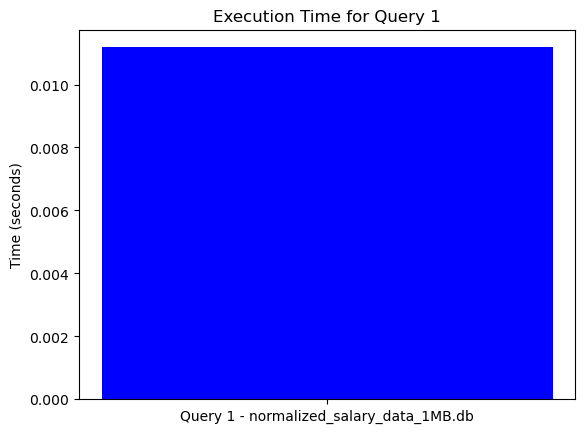

**Executing Query 1 on normalized_salary_data_10MB.db**

SQL Query:
```sql

    SELECT p.PersonName
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    WHERE p.BirthDate < '1975-01-01' 
    AND fr.Earnings > 130000
    AND fr.EarningsYear = (
        SELECT MAX(EarningsYear) 
        FROM FinancialRecord fr2
        WHERE fr2.PersonID = p.PersonID
    );
    
```

**Execution Time: 0.0472 seconds**

,PersonName
0,Charles Poole
1,Vincent Walsh
2,Brianna Thompson
3,Kevin Wood
4,Keith Robertson
...,...
6149,Andrea Esparza
6150,Ashley Clarke
6151,John Hughes
6152,Sandra Turner


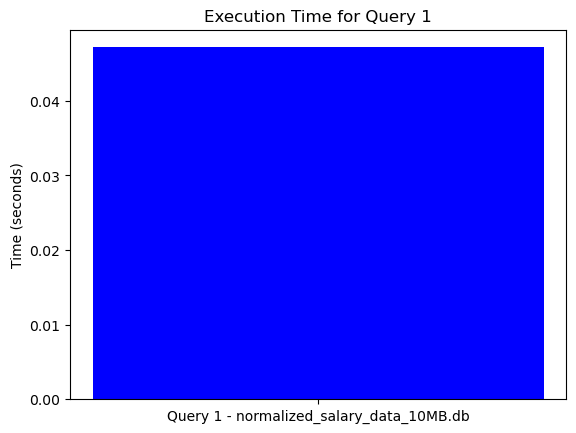

**Executing Query 1 on normalized_salary_data_100MB.db**

SQL Query:
```sql

    SELECT p.PersonName
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    WHERE p.BirthDate < '1975-01-01' 
    AND fr.Earnings > 130000
    AND fr.EarningsYear = (
        SELECT MAX(EarningsYear) 
        FROM FinancialRecord fr2
        WHERE fr2.PersonID = p.PersonID
    );
    
```

**Execution Time: 0.4460 seconds**

,PersonName
0,Theodore Stewart
1,Theodore Stewart
2,Joel Fuller
3,Jennifer Patrick MD
4,Brandon Williams
...,...
61044,Christopher Hogan
61045,Christopher Hogan
61046,Tammy Sweeney
61047,Matthew Pruitt


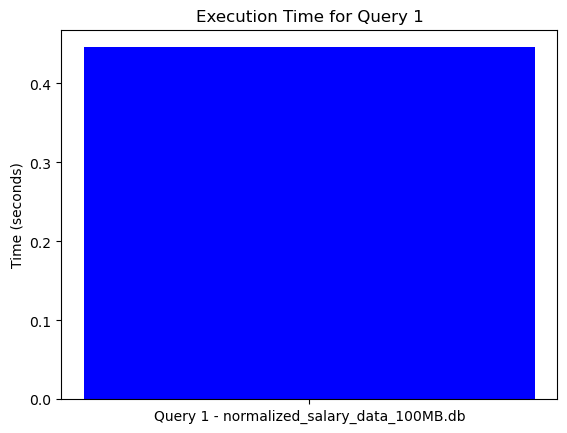

**Executing Query 2 on normalized_salary_data_1MB.db**

SQL Query:
```sql

    SELECT p.PersonName, s.SchoolName
    FROM FinancialRecord fr
    JOIN Person p ON fr.PersonID = p.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE fr.Earnings > 400000
      AND fr.StillWorking = 'no';
    
```

**Execution Time: 0.0039 seconds**

,PersonName,SchoolName
0,Amber Solomon,University of Texas
1,Valerie Harvey,University of Massachusetts
2,Robert Moran,University of Florida
3,Amber Hartman,University of Massachusetts
4,Amber Hartman,University of Massachusetts
...,...,...
914,Joshua Davis,University of Texas
915,Joshua Davis,University of Texas
916,Sarah Harris,University of Massachusetts
917,Cynthia Boyer,University of Massachusetts


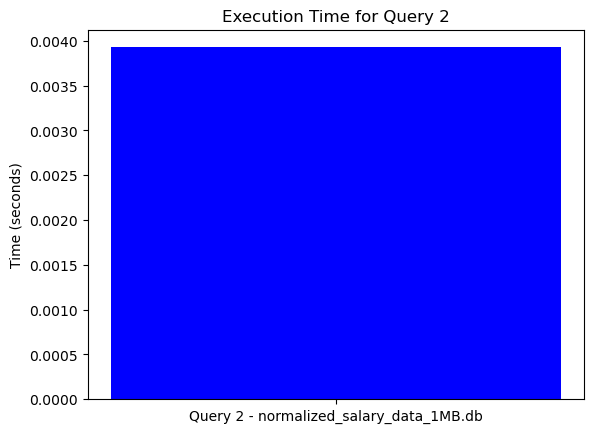

**Executing Query 2 on normalized_salary_data_10MB.db**

SQL Query:
```sql

    SELECT p.PersonName, s.SchoolName
    FROM FinancialRecord fr
    JOIN Person p ON fr.PersonID = p.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE fr.Earnings > 400000
      AND fr.StillWorking = 'no';
    
```

**Execution Time: 0.0369 seconds**

,PersonName,SchoolName
0,Charles Poole,University of Illinois
1,Vincent Walsh,University of Texas
2,David Lang,University of Illinois
3,Brianna Thompson,University of Massachusetts
4,Keith Robertson,University of Florida
...,...,...
8134,Rachel Weiss,University of Florida
8135,Christopher Hernandez,University of Florida
8136,Mrs. Diane Perry,University of Illinois
8137,Danielle Adams,University of Florida


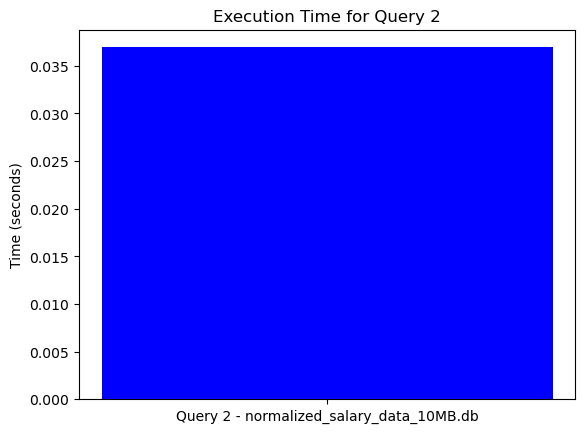

**Executing Query 2 on normalized_salary_data_100MB.db**

SQL Query:
```sql

    SELECT p.PersonName, s.SchoolName
    FROM FinancialRecord fr
    JOIN Person p ON fr.PersonID = p.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE fr.Earnings > 400000
      AND fr.StillWorking = 'no';
    
```

**Execution Time: 0.3213 seconds**

,PersonName,SchoolName
0,Christopher Barajas,University of California
1,Theodore Stewart,University of Texas
2,Jennifer Patrick MD,University of California
3,Brandon Williams,University of California
4,Brandon Williams,University of California
...,...,...
86021,Keith Arias,University of Florida
86022,Jason Morrison,University of Texas
86023,Matthew Pruitt,University of Illinois
86024,Michael Kemp,University of Illinois


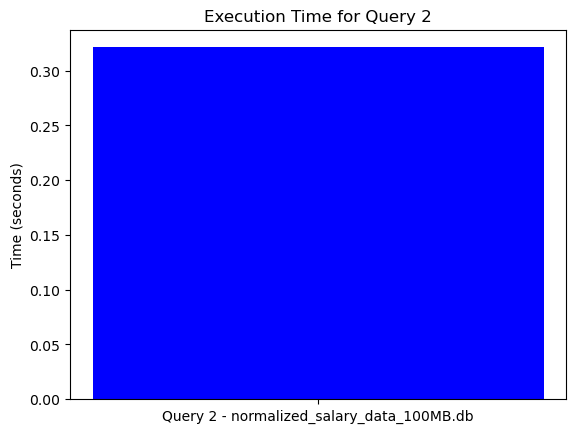

**Executing Query 3 on normalized_salary_data_1MB.db**

SQL Query:
```sql

    SELECT DISTINCT p.PersonName 
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE s.SchoolName = 'University of Texas'
    AND jr.JobTitle = 'Lecturer'
    AND fr.StillWorking = 'no';
    
```

**Execution Time: 0.0094 seconds**

,PersonName
0,Jackson Becker
1,Veronica Blackburn
2,Kayla Stevenson
3,Scott Castillo
4,Crystal Martin
...,...
151,Michael Aguilar
152,Kevin Dean
153,Louis Leblanc
154,Scott Mcclure


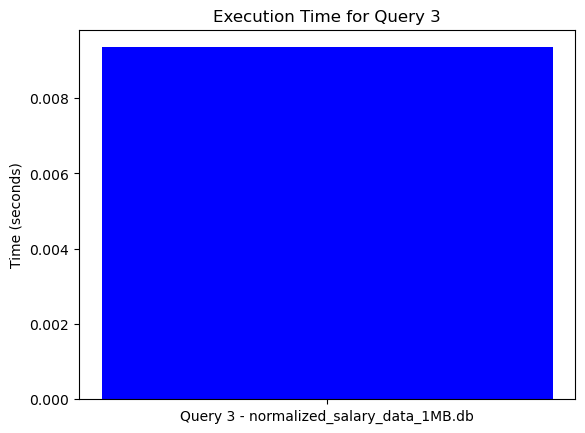

**Executing Query 3 on normalized_salary_data_10MB.db**

SQL Query:
```sql

    SELECT DISTINCT p.PersonName 
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE s.SchoolName = 'University of Texas'
    AND jr.JobTitle = 'Lecturer'
    AND fr.StillWorking = 'no';
    
```

**Execution Time: 0.0599 seconds**

,PersonName
0,Devin Cardenas
1,Kevin Wood
2,Zachary Moreno
3,Roger Guerrero
4,Grace Brown
...,...
1266,Joseph Thomas
1267,Monica Bowers
1268,Erik Gutierrez
1269,Nicholas Cook


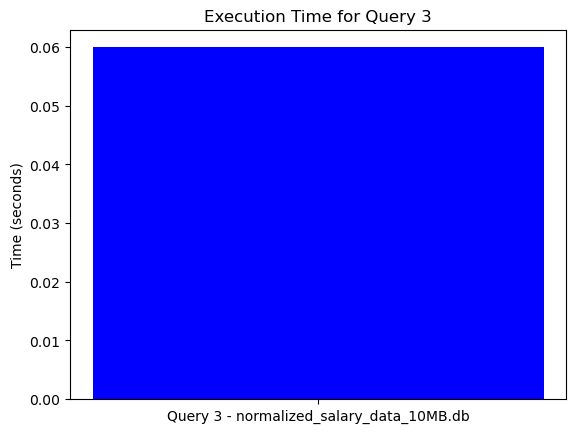

**Executing Query 3 on normalized_salary_data_100MB.db**

SQL Query:
```sql

    SELECT DISTINCT p.PersonName 
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE s.SchoolName = 'University of Texas'
    AND jr.JobTitle = 'Lecturer'
    AND fr.StillWorking = 'no';
    
```

**Execution Time: 0.5493 seconds**

,PersonName
0,Theodore Stewart
1,Karen Potts
2,John Rodriguez
3,Kristina Macias
4,Carlos Mullins
...,...
7027,Jose Green
7028,Tina Melton
7029,Carla Barnes
7030,Ryan Rubio


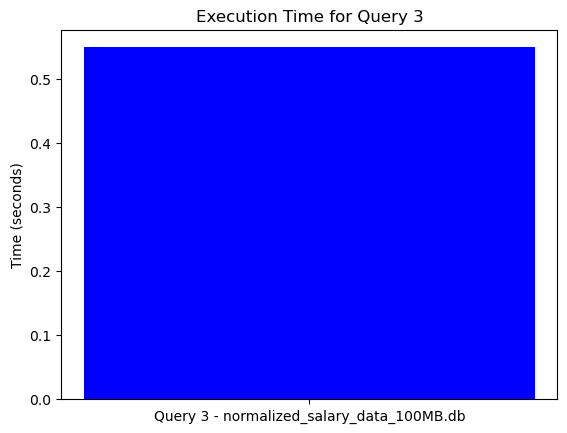

**Executing Query 4 on normalized_salary_data_1MB.db**

SQL Query:
```sql

    WITH ActiveFacultyCount AS (
        SELECT s.SchoolName, c.SchoolCampus, COUNT(DISTINCT p.PersonID) as ActiveFacultyCount
        FROM Person p
        JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
        JOIN JobRecord jr ON fr.JobID = jr.JobID
        JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
        JOIN School s ON c.SchoolID = s.SchoolID
        WHERE fr.StillWorking = 'yes'
        GROUP BY s.SchoolName, c.SchoolCampus
    )
    SELECT SchoolName, SchoolCampus, ActiveFacultyCount
    FROM ActiveFacultyCount
    ORDER BY ActiveFacultyCount DESC
    LIMIT 1;
    
```

**Execution Time: 0.0061 seconds**

,SchoolName,SchoolCampus,ActiveFacultyCount
0,University of Illinois,Springfield,69


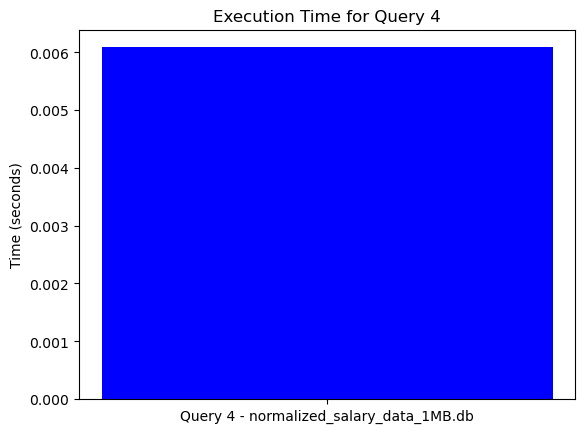

**Executing Query 4 on normalized_salary_data_10MB.db**

SQL Query:
```sql

    WITH ActiveFacultyCount AS (
        SELECT s.SchoolName, c.SchoolCampus, COUNT(DISTINCT p.PersonID) as ActiveFacultyCount
        FROM Person p
        JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
        JOIN JobRecord jr ON fr.JobID = jr.JobID
        JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
        JOIN School s ON c.SchoolID = s.SchoolID
        WHERE fr.StillWorking = 'yes'
        GROUP BY s.SchoolName, c.SchoolCampus
    )
    SELECT SchoolName, SchoolCampus, ActiveFacultyCount
    FROM ActiveFacultyCount
    ORDER BY ActiveFacultyCount DESC
    LIMIT 1;
    
```

**Execution Time: 0.0370 seconds**

,SchoolName,SchoolCampus,ActiveFacultyCount
0,University of Massachusetts,Dartmouth,273


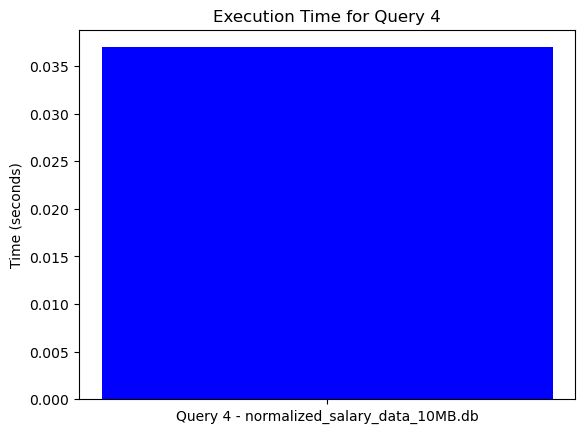

**Executing Query 4 on normalized_salary_data_100MB.db**

SQL Query:
```sql

    WITH ActiveFacultyCount AS (
        SELECT s.SchoolName, c.SchoolCampus, COUNT(DISTINCT p.PersonID) as ActiveFacultyCount
        FROM Person p
        JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
        JOIN JobRecord jr ON fr.JobID = jr.JobID
        JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
        JOIN School s ON c.SchoolID = s.SchoolID
        WHERE fr.StillWorking = 'yes'
        GROUP BY s.SchoolName, c.SchoolCampus
    )
    SELECT SchoolName, SchoolCampus, ActiveFacultyCount
    FROM ActiveFacultyCount
    ORDER BY ActiveFacultyCount DESC
    LIMIT 1;
    
```

**Execution Time: 0.2173 seconds**

,SchoolName,SchoolCampus,ActiveFacultyCount
0,University of Massachusetts,Dartmouth,2874


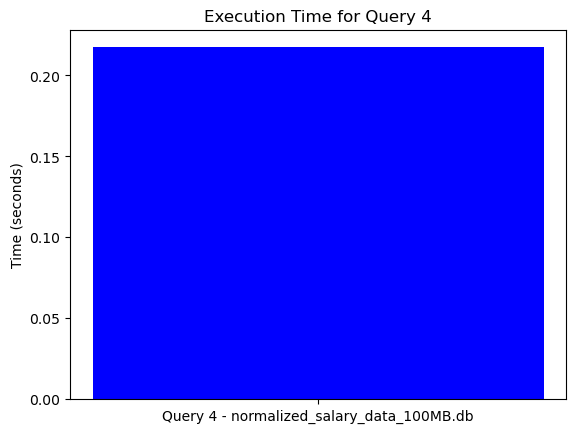

**Executing Query 5 on normalized_salary_data_1MB.db**

SQL Query:
```sql

    SELECT 
        p.PersonName, 
        jr.JobTitle, 
        d.DepartmentName, 
        s.SchoolName, 
        fr.Earnings
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Department d ON jr.DepartmentID = d.DepartmentID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE p.PersonName LIKE '%Vinay Shetye%'
    AND fr.EarningsYear = (
        SELECT MAX(EarningsYear)
        FROM FinancialRecord fr2
        WHERE fr2.PersonID = p.PersonID
    );
    
```

**Execution Time: 0.0168 seconds**

,PersonName,JobTitle,DepartmentName,SchoolName,Earnings
0,Vinay Shetye,Engineer,Computer Science,University of Massachusetts,275731.0


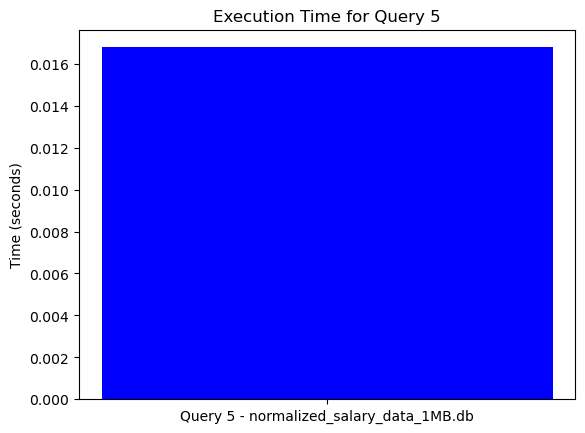

**Executing Query 5 on normalized_salary_data_10MB.db**

SQL Query:
```sql

    SELECT 
        p.PersonName, 
        jr.JobTitle, 
        d.DepartmentName, 
        s.SchoolName, 
        fr.Earnings
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Department d ON jr.DepartmentID = d.DepartmentID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE p.PersonName LIKE '%Vinay Shetye%'
    AND fr.EarningsYear = (
        SELECT MAX(EarningsYear)
        FROM FinancialRecord fr2
        WHERE fr2.PersonID = p.PersonID
    );
    
```

**Execution Time: 0.0286 seconds**

,PersonName,JobTitle,DepartmentName,SchoolName,Earnings
0,Vinay Shetye,Administrator,Chemistry,University of Massachusetts,165496.0


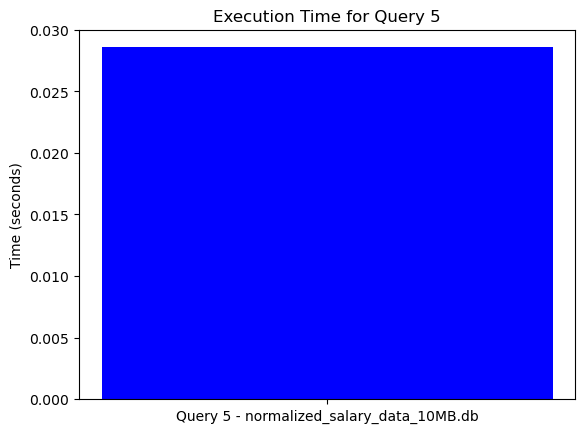

**Executing Query 5 on normalized_salary_data_100MB.db**

SQL Query:
```sql

    SELECT 
        p.PersonName, 
        jr.JobTitle, 
        d.DepartmentName, 
        s.SchoolName, 
        fr.Earnings
    FROM Person p
    JOIN FinancialRecord fr ON p.PersonID = fr.PersonID
    JOIN JobRecord jr ON fr.JobID = jr.JobID
    JOIN Department d ON jr.DepartmentID = d.DepartmentID
    JOIN Campus c ON jr.SchoolID = c.SchoolID AND jr.SchoolCampus = c.SchoolCampus
    JOIN School s ON c.SchoolID = s.SchoolID
    WHERE p.PersonName LIKE '%Vinay Shetye%'
    AND fr.EarningsYear = (
        SELECT MAX(EarningsYear)
        FROM FinancialRecord fr2
        WHERE fr2.PersonID = p.PersonID
    );
    
```

**Execution Time: 0.1786 seconds**

,PersonName,JobTitle,DepartmentName,SchoolName,Earnings
0,Vinay Shetye,Scientist,Computer Engineering,University of Massachusetts,330427.0


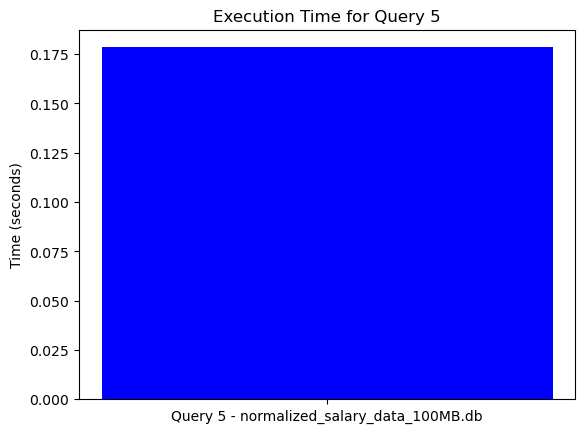

**Executing Query 6 on normalized_salary_data_1MB.db**

SQL Query:
```sql

    WITH DepartmentEarnings AS (
        SELECT 
            d.DepartmentName, 
            AVG(fr.Earnings) as AvgEarnings
        FROM FinancialRecord fr
        JOIN JobRecord jr ON fr.JobID = jr.JobID
        JOIN Department d ON jr.DepartmentID = d.DepartmentID
        GROUP BY d.DepartmentName
    )
    SELECT DepartmentName, AvgEarnings
    FROM DepartmentEarnings
    ORDER BY AvgEarnings DESC
    LIMIT 1;
    
```

**Execution Time: 0.0102 seconds**

,DepartmentName,AvgEarnings
0,Computer Engineering,251426.764364


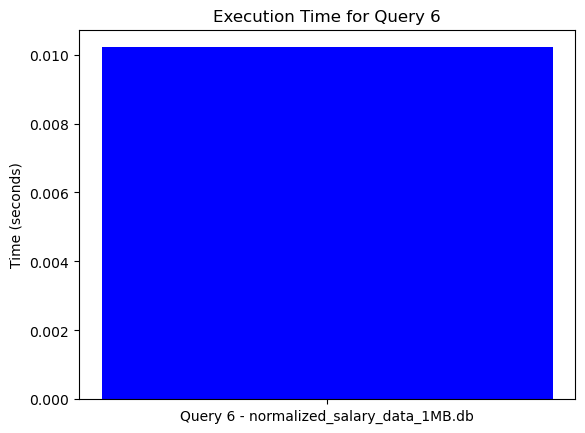

**Executing Query 6 on normalized_salary_data_10MB.db**

SQL Query:
```sql

    WITH DepartmentEarnings AS (
        SELECT 
            d.DepartmentName, 
            AVG(fr.Earnings) as AvgEarnings
        FROM FinancialRecord fr
        JOIN JobRecord jr ON fr.JobID = jr.JobID
        JOIN Department d ON jr.DepartmentID = d.DepartmentID
        GROUP BY d.DepartmentName
    )
    SELECT DepartmentName, AvgEarnings
    FROM DepartmentEarnings
    ORDER BY AvgEarnings DESC
    LIMIT 1;
    
```

**Execution Time: 0.1071 seconds**

,DepartmentName,AvgEarnings
0,Biology,240280.589775


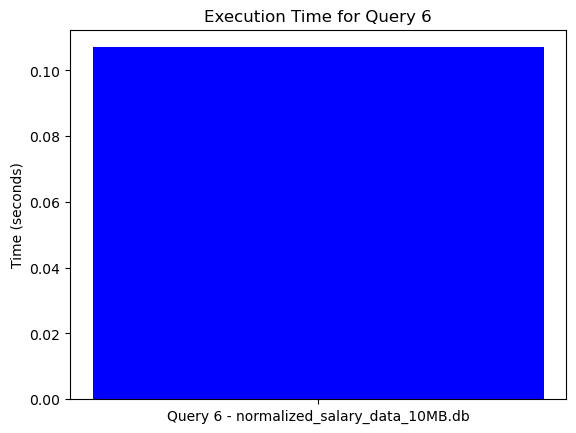

**Executing Query 6 on normalized_salary_data_100MB.db**

SQL Query:
```sql

    WITH DepartmentEarnings AS (
        SELECT 
            d.DepartmentName, 
            AVG(fr.Earnings) as AvgEarnings
        FROM FinancialRecord fr
        JOIN JobRecord jr ON fr.JobID = jr.JobID
        JOIN Department d ON jr.DepartmentID = d.DepartmentID
        GROUP BY d.DepartmentName
    )
    SELECT DepartmentName, AvgEarnings
    FROM DepartmentEarnings
    ORDER BY AvgEarnings DESC
    LIMIT 1;
    
```

**Execution Time: 1.2460 seconds**

,DepartmentName,AvgEarnings
0,Computer Engineering,236908.27057


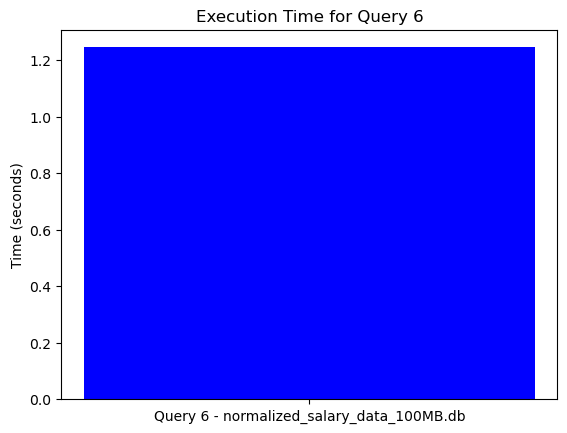

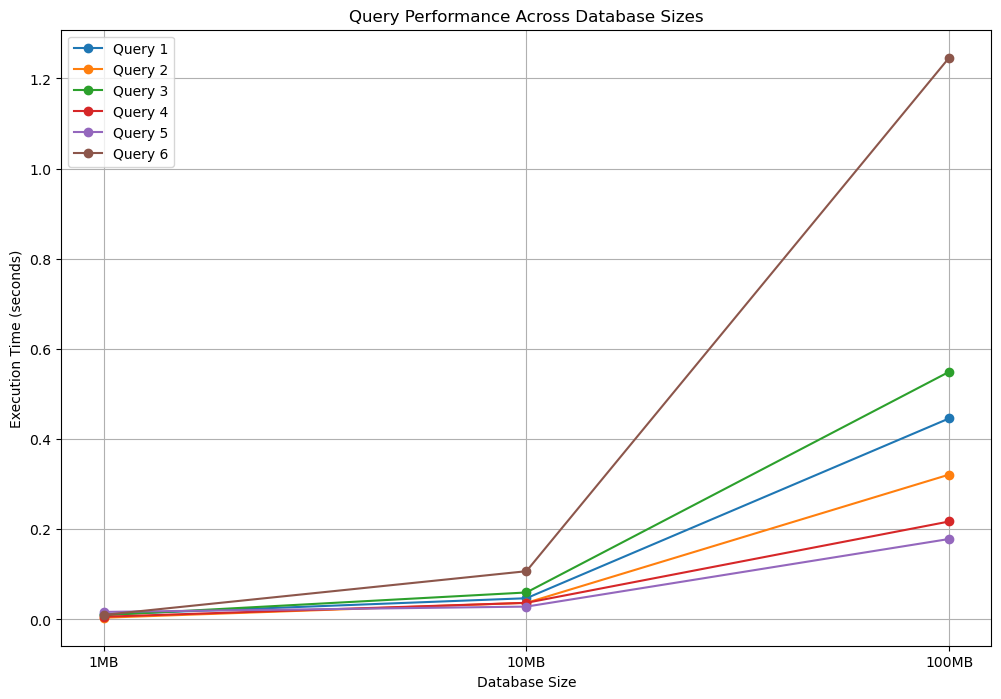

****Performance Summary (seconds):****

,Query 1,Query 2,Query 3,Query 4,Query 5,Query 6
1MB,0.011190,0.003929,0.009351,0.006088,0.016803,0.010219
10MB,0.047168,0.036950,0.059940,0.036973,0.028589,0.107092
100MB,0.445985,0.321338,0.549342,0.217345,0.178567,1.245963


In [6]:
performance_results = {query_num: [] for query_num in queries.keys()}
db_names = [
    "normalized_salary_data_1MB.db",
    "normalized_salary_data_10MB.db",
    "normalized_salary_data_100MB.db",
]

for query_num, query_template in queries.items():
    for db_name in db_names:
        time_taken = measure_query_performance(db_name, query_template, query_num)
        performance_results[query_num].append(time_taken)

file_sizes = ["1MB", "10MB", "100MB"]

plt.figure(figsize=(12, 8))
for query_num, times in performance_results.items():
    plt.plot(file_sizes, times, marker='o', label=f'Query {query_num}')

plt.title('Query Performance Across Database Sizes')
plt.xlabel('Database Size')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

summary_df = pd.DataFrame(performance_results, index=file_sizes)
summary_df.columns = [f'Query {i}' for i in range(1, len(queries) + 1)]

display_formatted_output("**Performance Summary (seconds):**", True)
display(summary_df)